# Lesson 11: Multimodal

[SHORT_DESCRIPTION]

We will use the `google-genai` library to interact with Google's Gemini models.

**Learning Objectives:**

1.  

## 1. Setup

First, let's install the necessary Python libraries using pip.

!pip install -q google-genai pydantic python-dotenv

### Configure Gemini API Key

To use the Gemini API, you need an API key. 

1.  Get your key from [Google AI Studio](https://aistudio.google.com/app/apikey).
2.  Create a file named `.env` in the root of this project.
3.  Add the following line to the `.env` file, replacing `your_api_key_here` with your actual key:
    ```
    GOOGLE_API_KEY="your_api_key_here"
    ```
The code below will load this key from the `.env` file.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lessons.utils import env

env.load(required_env_vars=["GOOGLE_API_KEY"])

Trying to load environment variables from `/Users/pauliusztin/Documents/01_projects/TAI/course-ai-agents/.env`
Environment variables loaded successfully.


### Import Key Packages

In [3]:
import io
import base64
from typing import Literal
from IPython.display import Image as IPythonImage
from PIL import Image as PILImage
from google import genai
from google.genai import types
from pathlib import Path

from lessons.utils import pretty_print

### Initialize the Gemini Client

In [4]:
client = genai.Client()

### Define Constants

We will use the `gemini-2.5-flash` model, which is fast, cost-effective, and supports advanced features like tool use.

In [5]:
MODEL_ID = "gemini-2.5-flash"

## 2. Applying multimodal LLMs to images, PDFs, and text

There are core ways we can process images and PDFs with multimodal models:
1. As URLs
2. As BASE64

First, let's look at a test image:


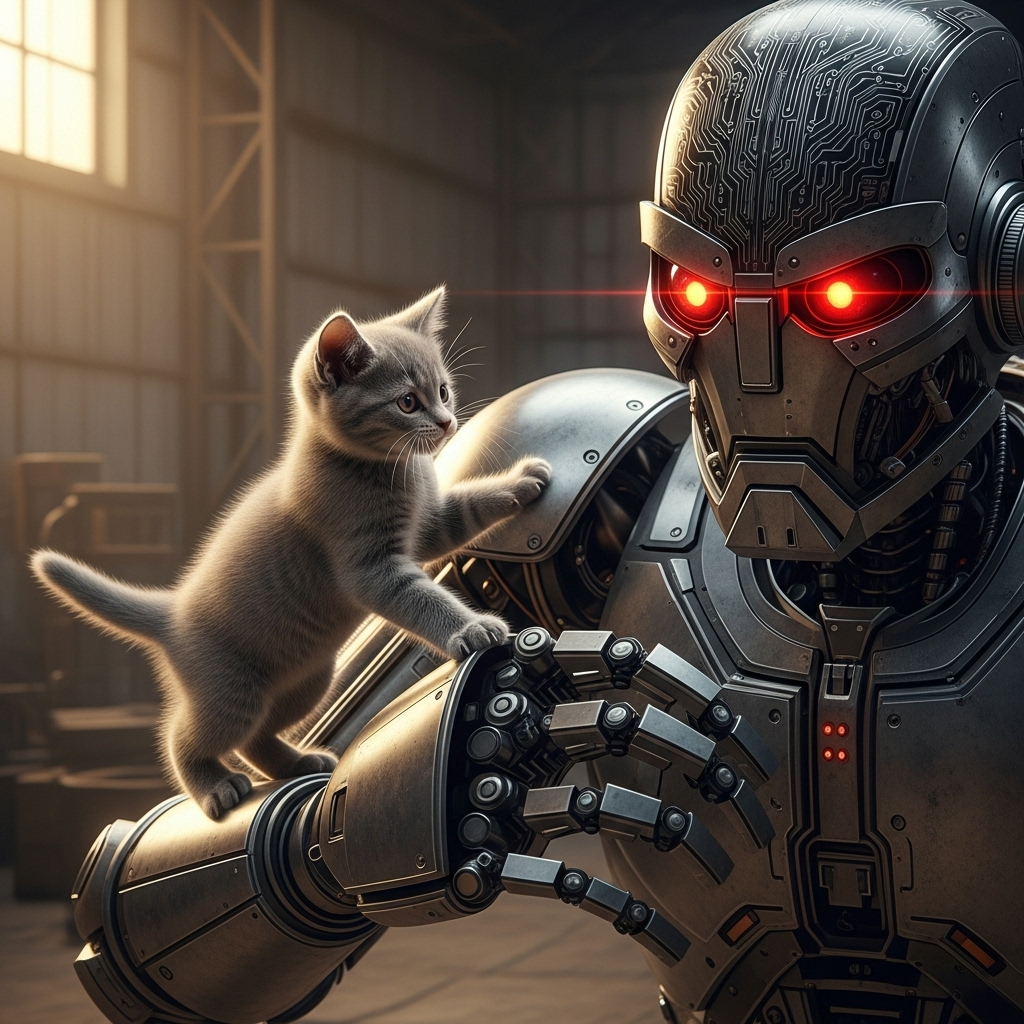

In [6]:
def display_image(image_path: Path) -> None:
    image = IPythonImage(filename=image_path, width=400)
    display(image)


display_image(Path("images") / "image_1.png")

### 2.1 As bytes

In [7]:
def load_image_as_bytes(
    image_path: Path, format: Literal["WEBP", "JPEG", "PNG"] = "WEBP", max_width: int = 600, return_size: bool = False
) -> bytes | tuple[bytes, tuple[int, int]]:
    image = PILImage.open(image_path)
    if image.width > max_width:
        ratio = max_width / image.width
        new_size = (max_width, int(image.height * ratio))
        image = image.resize(new_size)

    byte_stream = io.BytesIO()
    image.save(byte_stream, format=format)

    if return_size:
        return byte_stream.getvalue(), image.size

    return byte_stream.getvalue()

In [8]:
image_bytes = load_image_as_bytes(image_path=Path("images") / "image_1.png", format="WEBP")

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(
            data=image_bytes,
            mime_type="image/webp",
        ),
        "Tell me what is in this image in one paragraph.",
    ],
)
pretty_print.wrapped(response.text, title="Image 1 Caption")


----------------------------------------- Image 1 Caption -----------------------------------------
  This image depicts a striking contrast between a small, fluffy grey tabby kitten and a large, imposing metallic robot within what appears to be an industrial or workshop setting. The curious kitten is perched on the robot's substantial left arm and shoulder, its paw gently resting or playfully batting against the hard, textured surface. The robot is intricately designed with dark, armored plating, detailed circuit-like patterns etched across its head, and glowing red eyes that emit an intense, focused gaze. Its mechanical limbs feature articulated joints and visible components, highlighting its robust construction. The soft, delicate appearance of the kitten creates an endearing juxtaposition with the robot's formidable, high-tech aesthetic, suggesting an unexpected moment of interaction between nature and advanced machinery.
------------------------------------------------------------

In [9]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(
            data=load_image_as_bytes(image_path=Path("images") / "image_1.png", format="WEBP"),
            mime_type="image/webp",
        ),
        types.Part.from_bytes(
            data=load_image_as_bytes(image_path=Path("images") / "image_2.png", format="WEBP"),
            mime_type="image/webp",
        ),
        "What's the difference between these two images? Describe it in one paragraph.",
    ],
)
pretty_print.wrapped(response.text, title="Differences between images")


------------------------------------ Differences between images ------------------------------------
  The most significant difference between the two images lies in the **interaction between the animal and the robot, as well as the overall atmosphere and setting**. The first image portrays a small, grey kitten curiously perched on the arm of a large, silver robot in a bright, industrial-looking space, conveying a sense of gentle observation or unlikely companionship. In stark contrast, the second image depicts a tense and aggressive confrontation between a large, white dog and a sleek, black robot in a grimy, trash-strewn urban alley, with both figures in combative stances, suggesting an imminent struggle.
----------------------------------------------------------------------------------------------------


### 2.2 As BASE64

For local files or when you need to encode images directly, you can use BASE64 encoding. This approach is preferred over raw bytes because strings are more reliable for transmission and storage.


In [10]:
def load_image_as_base64(
    image_path: Path, format: Literal["WEBP", "JPEG", "PNG"] = "WEBP", max_width: int = 600, return_size: bool = False
) -> str:
    image_bytes = load_image_as_bytes(
        image_path=image_path, format=format, max_width=max_width, return_size=return_size
    )
    return base64.b64encode(image_bytes).decode("utf-8")

In [11]:
image_base64 = load_image_as_base64(image_path=Path("images") / "image_1.png", format="WEBP")
pretty_print.wrapped(image_base64, title="Image 1 Base64")

------------------------------------------ Image 1 Base64 ------------------------------------------
  UklGRr64AABXRUJQVlA4ILK4AADw/AKdASpYAlgCPm0wlEekIqIup5RrcdANiWduH8IDKEjGINoqKMRmdM5YMPr1sYwMv/R9LyfHWuQn0KMo507kn1Ri25W/OGevkgfLz1I8vJ7T+dH6Gvq1/RL6anybs3k86vzbr5/N/sn+B/iv3k+JH9Rzj+8/5/md/QP0F/a/zftr/x/Bn9d/qv/T6h3ub/m+t1C/1T/7/qNfBX4j/v/5n18vwP/N6Vfw/+r/9PuBfr7/1PLS8Uj83/2vYF/qH9//8H+V94z/U//H+59Kn1x/8v9l8CX9G/wf/j9ez/8/+f4Xfut////X8PX7gf/8wlhyacSKPOw/DMH2ZRsbq8bXQY91LYBpzoXJReSCVwRWpbrVr8rYJL8D1Lbko8FkTD7SAtTVl/o37TS39/y5dowiHaM/qFvZPuBKi/5IWbkurpjDSfuA1koLfIgAuquCJbzRoON3fIBYBZLLY/u+6B6f+15yQ5NuUTFIBYvY2V/OALVBgmlfFrsxI1rLkwvtB42ZKyD+1dnbS2WBJlhqndKn4Iinol/AYp9gjb+71/yy1DOwdSFPRfoZhkfWGi/gkWBvroBYETbKN2FatYG9eOmP/5bV4KZsMI0SNqKez9ycUCzn3wfWCdruLdhroL9+TZUNhi5hhXXLJhIyyHBQGbt6W81SVj0yXEJtqMX2xzpR25freJSwlQXnaEZpBtLru/owRzM1ATr8sGV9V/dL8m7JlHbxnbLxWgAmm8qlrkpHo5H7pViRLNOF98q3jiLmBkr6ff/B6eycRqt1WykwGKqq/PEX1ImGVoDHDhdOs0zAA57qeYVXfZJXwheKfnM7N/6FIH+2BtGSpsjN6D844XlVaXCiyNKNmT6P6RyZM

In [12]:
response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(data=image_base64, mime_type="image/webp"),
        "Tell me what is in this image in one paragraph.",
    ],
)
response.text


"The image displays a striking scene featuring a small, fluffy gray tabby kitten interacting with a large, imposing humanoid robot. The kitten is perched playfully on the robot's left arm, with one paw resting gently on its metallic shoulder and its gaze directed towards the robot's face. The robot itself is constructed of dark, intricate metallic components, with its head detailed by circuit board patterns and prominent, glowing red eyes that pierce the semi-darkness. They are situated within what appears to be an industrial or workshop environment, indicated by the metallic structures and diffuse, warm light entering from a window on the left, creating an unusual and captivating contrast between organic life and advanced machinery."

### 2.3 Object detection with vLLMs

In [13]:
from pydantic import BaseModel, Field
from typing import cast


class BoundingBox(BaseModel):
    ymin: float
    xmin: float
    ymax: float
    xmax: float
    label: str = Field(default="The object found within the bounding box.")


class Detections(BaseModel):
    bounding_boxes: list[BoundingBox]


client = genai.Client()
prompt = """
Detect the all of the prominent items in the image. The box_2d should be [ymin, xmin, ymax, xmax] normalized to 0-1000.
"""

image_bytes, image_size = load_image_as_bytes(
    image_path=Path("images") / "image_1.png", format="WEBP", return_size=True
)

config = types.GenerateContentConfig(
    response_mime_type="application/json",
    response_schema=Detections,
)

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        types.Part.from_bytes(
            data=image_bytes,
            mime_type="image/webp",
        ),
        prompt,
    ],
    config=config,
)

width, height = image_size
print("Image size: ", width, height)
detections = cast(Detections, response.parsed)

for bounding_box in detections.bounding_boxes:
    bounding_box.ymin = int(bounding_box.ymin / 1000 * height)
    bounding_box.xmin = int(bounding_box.xmin / 1000 * width)
    bounding_box.ymax = int(bounding_box.ymax / 1000 * height)
    bounding_box.xmax = int(bounding_box.xmax / 1000 * width)
    print(bounding_box)

Image size:  600 600
ymin=0 xmin=256 ymax=591 xmax=600 label='robot'
ymin=163 xmin=16 ymax=480 xmax=321 label='kitten'


### 2.4 Working with PDFs

PDFs can be processed similarly to images. Gemini can understand PDF documents directly without requiring OCR preprocessing.


In [14]:
def load_pdf_as_base64(pdf_path: Path) -> str:
    with open(pdf_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

In [15]:
pdf_base64 = load_pdf_as_base64(pdf_path=Path("pdfs") / "decoding_ml_article.pdf")

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        "What is this document about? Provide a brief summary of the main topics.",
        types.Part.from_bytes(data=pdf_base64, mime_type="application/pdf"),
    ],
)

pretty_print.wrapped(response.text, title="PDF Summary")


------------------------------------------- PDF Summary -------------------------------------------
  This document is a blog post titled "5 Books to Ship AI Products in 2025: LLMs & Agents" by Paul Iusztin. It presents a curated list of five (plus one bonus) book recommendations for individuals aiming to develop and deploy AI products, particularly those involving Large Language Models (LLMs) and agentic systems, in a production environment.

The main topics covered by the recommended books and discussed in the article include:

*   **Fundamentals of Machine Learning and AI Systems:** Building end-to-end ML and AI systems, including architecture, MLOps, and infrastructure.
*   **Prompt Engineering for LLMs:** Techniques for designing effective, flexible, and scalable prompts for large language models.
*   **Building and Deploying LLM Applications:** Practical guidance on implementing core LLM algorithms, using frameworks like LangChain and LlamaIndex, and deploying LLMs to production.

In [16]:
uploaded_pdf = client.files.upload(file=Path("pdfs") / "decoding_ml_article.pdf")

response = client.models.generate_content(
    model=MODEL_ID,
    contents=[
        uploaded_pdf,
        "What is this document about? Provide a brief summary of the main topics.",
    ],
)
pretty_print.wrapped(response.text, title="PDF Summary")

------------------------------------------- PDF Summary -------------------------------------------
  This document is an article titled "5 Books to Ship AI Products in 2025: LLMs & Agents," which provides a curated list of recommended books for AI engineering, particularly focusing on Large Language Models (LLMs) and agentic systems.

The main topics covered include:
*   **Designing and Architecting Machine Learning/AI Systems:** Fundamental concepts for building production-grade ML/AI pipelines, MLOps, and infrastructure.
*   **Prompt Engineering for LLMs:** Techniques for effectively designing prompts to optimize LLM performance and scalability.
*   **Building LLMs for Production:** Hands-on guidance on implementing LLM applications, including RAG (Retrieval-Augmented Generation) techniques, fine-tuning, and using frameworks like LangChain and LlamaIndex.
*   **Deploying and Scaling LLMs:** Strategies for optimizing, serving, and managing LLMs in production environments, covering as

## 3. Using multimodal embeddings for images and text

# 4. Implementing multimodal RAG for images and text

In [21]:
from langchain_community.vectorstores import InMemoryVectorStore
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.schema import Document
from pathlib import Path
from PIL import Image
from io import BytesIO

# 1. Set up embeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

# 2. Prepare data
texts = ["Sample document 1", "Sample document 2"]
image_path = Path("images") / "image_1.png"

def load_image_as_bytes(image_path, format="WEBP"):
    img = Image.open(image_path)
    buf = BytesIO()
    img.save(buf, format=format)
    return buf.getvalue()

image_bytes = load_image_as_bytes(image_path, format="WEBP")

docs = [
    Document(page_content="Sample document 1", metadata={"type": "text"}),
    Document(page_content="Sample document 2", metadata={"type": "text"}),
    Document(page_content="image_1.png", metadata={"type": "image", "image_bytes": image_bytes}),
]

# 3. Compute embeddings for all docs
def custom_embedding(doc):
    if doc.metadata.get("type") == "image":
        return embeddings.embed_documents([doc.metadata["image_bytes"]])[0]
    else:
        return embeddings.embed_documents([doc.page_content])[0]

vectors = [custom_embedding(doc) for doc in docs]

# 4. Create InMemoryVectorStore
vector_store = InMemoryVectorStore(embedding=embeddings)
vector_store.add_embeddings(vectors, docs)

# 5. Query with text
query = "query about documents"
query_embedding = embeddings.embed_query(query)
results = vector_store.similarity_search_by_vector(query_embedding, k=3)
for doc in results:
    print(doc.page_content, doc.metadata)

TypeError: cannot use a string pattern on a bytes-like object

## 5. Building multimodal AI agents